In [1]:
#import packages
import time
import numpy as np
import capytaine as cpt
import scipy
from capytaine.io.mesh_writers import write_STL
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import logging
import xarray as xr
from capytaine.io.xarray import merge_complex_values
from capytaine.post_pro import rao
logging.basicConfig(level=logging.INFO, format='%(levelname)-8s: %(message)s')

# Import custom package
import DM_Assemble as DM_A
import DM_Reading  as DM_R
import DM_ShowNodes as DMshow
import DM_Verify as DM_V
import DM_Windload as DM_Wind

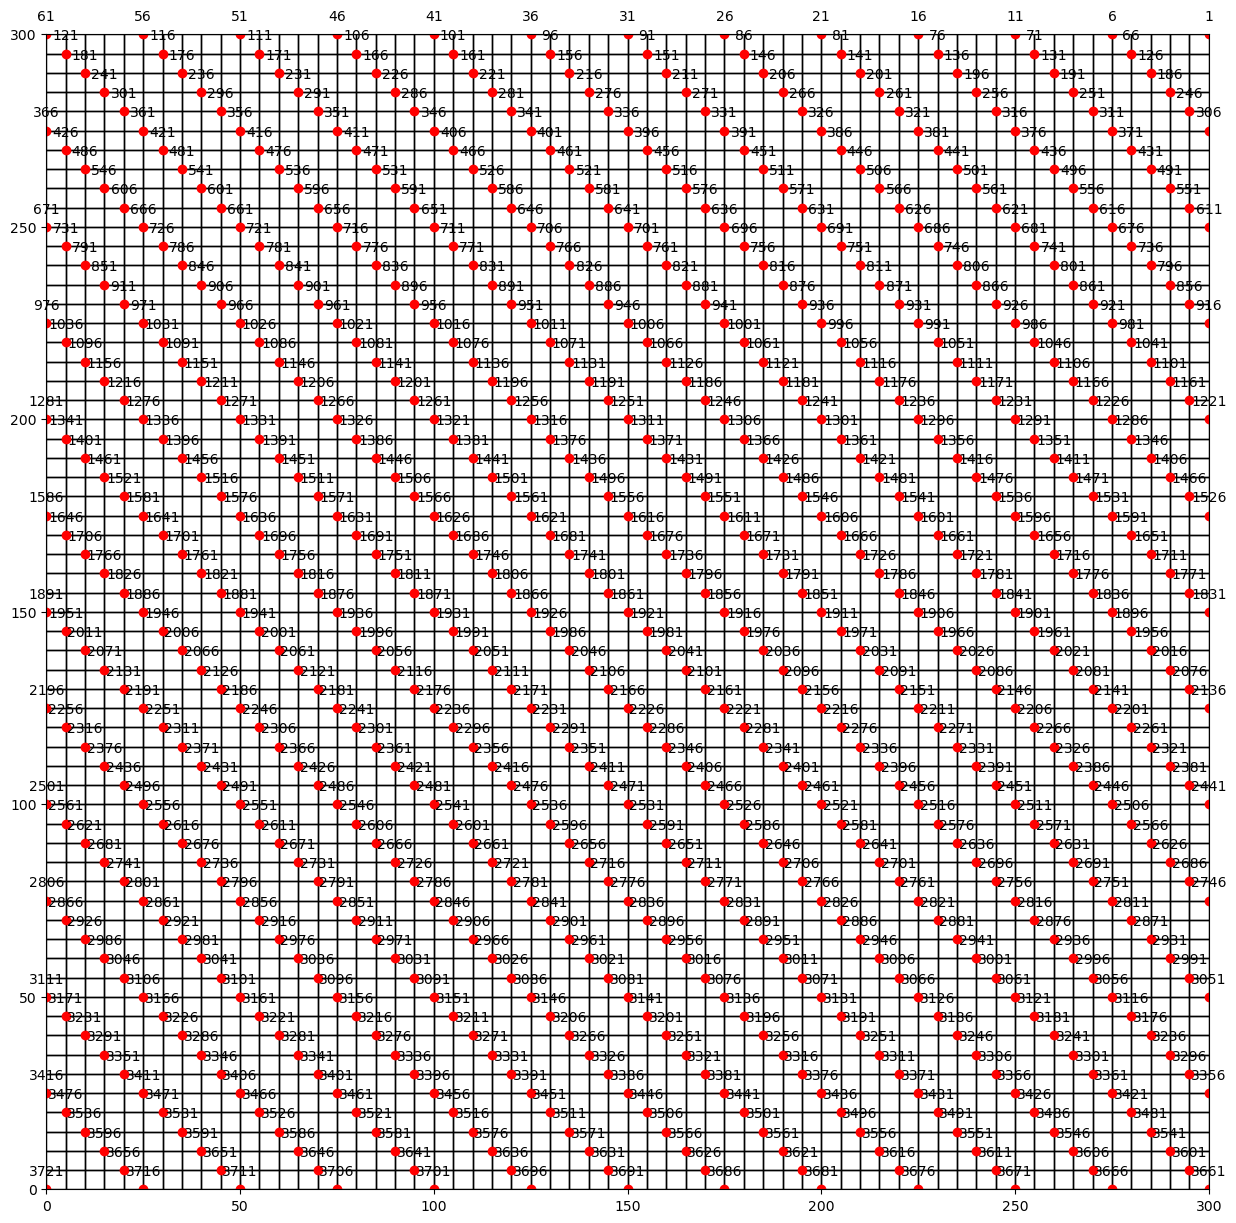

In [34]:
# Show nodes
file_path = "data\model300_300\plate334.inp"
label_interval = 5
elements = DMshow.plot_fea_model(file_path, label_interval)

In [ ]:
len(elements)

In [ ]:
# Example usage:
DM_V.verify_hydrodynamic_data("winddata\DM10_145_direction0.nc",wave_direction=0)

In [ ]:
# main 
if __name__ == "__main__":
    N = 793   # Suppose the number of nodes is 793 63

    # Obtain the dataset
    dataset = merge_complex_values(xr.open_dataset("winddata\DM10_145_direction0.nc")) # << Change
    # Here we use 1.0 as an example, in actual applications you should use your real data
    omega = 0.648   #<<<<<<<< Change

    # Obtain the structural stiffness matrix
    file_path = "winddata\Job-1_STIF1.mtx"  # Replace with your file path

    # Extract matrices and force from the dataset
    added_mass = dataset['added_mass'][0].values
    radiation_damping = dataset['radiation_damping'][0].values
    inertia_matrix = dataset['inertia_matrix'].values
    hydrostatic_stiffness = dataset['hydrostatic_stiffness'].values
    F_w = dataset['Froude_Krylov_force'][0].values + dataset['diffraction_force'][0].values
    
    # Construct the combined matrices
    M = added_mass + inertia_matrix  # Total mass
    C = radiation_damping  # Damping
    K = hydrostatic_stiffness  # Stiffness
    
    # Sample node ID list
    # node_ids = [41, 39, 37, 35, 33, 31, 29, 27, 25, 23]
    # node_ids = DM_A.calculate_2d_node_positions_descending(3535,6,61,10,10) # Calculate the node positionscalculate_node_positions(425,6,10) 
    # node_ids = list(reversed(DM_A.calculate_node_positions(424,6,10))) #反转
    node_ids = DM_A.calculate_node_positions(424,6,10)
    print(node_ids)
    
    # print(node_ids)
    # Call function to insert the additional mass stiffness matrix into the total stiffness matrix
    mass = DM_A.insert_martix(N, M, node_ids)
    damping = DM_A.insert_martix(N, C, node_ids)
    hy_stiffness = DM_A.insert_martix(N, K, node_ids)
    stiffness = DM_R.get_stiffness_matrix(file_path) + hy_stiffness
    # Assemble the force matrix
    K_F_w = DM_A.extend_force_matrix(F_w, node_ids, N)
    # 开始计时
    start_time = time.time()
    X = DM_A.solve_frequency_domain(mass, damping, stiffness, K_F_w, omega)  # Solve in frequency domain
    end_time = time.time()
    # 计算运行时间
    runtime = end_time - start_time
    # 打印运行时间
    print(f"代码的运行时间为: {runtime} 秒") 
    # 保存X
    # np.save('result.npy', X)
#     # 在需要时加载X
#     X_loaded = np.load('result.npy')


## 细长水弹性板的验证

In [ ]:
# forceAnalysis
from DM_forec_analysis import ForceAnalysis
analyzer = ForceAnalysis(N=793, H=13, module_nodes=7, module_number=10, element_length=5, element_width=5)

# Compute module displacements using the provided displacement matrix X
module_displacements = analyzer.compute_module_displacements(displacement_matrix=X)

# Fetch the stiffness matrix for an element from a specified file
K_element = DM_R.get_stiffness_matrix("winddata\sub_m10_w60.mtx")

# Compute forces within the module using the stiffness matrix and module displacements
module_forces = analyzer.compute_module_forces(K_element, module_displacements)

# Map the forces from module level to global nodes
global_forces = analyzer.map_forces_to_global_nodes(module_forces)

# Visualize global forces using a plot
analyzer.plot_forces(global_forces)

M = analyzer.get_middle_interface_forces(global_forces)
# # Display global forces as a 2D heatmap
# analyzer.plot_2D_heatmap(global_forces)

# # Display global forces as a 3D surface plot
# analyzer.plot_3D_surface(global_forces)

In [ ]:
# Show heave displacement
import matplotlib.pyplot as plt
displacement = X
# 提取中轴线上的节点位移
mid_axis_nodes_start = 367  # 起始节点
mid_axis_nodes_end = 427 # 结束节点

# 由于每个节点有6个自由度，我们需要找到与这些节点对应的位移
mid_axis_displacement = displacement[(mid_axis_nodes_start-1)*6:(mid_axis_nodes_end)*6:6, :]

# 垂荡位移应该是Y轴（第2个自由度）的位移，我们需要每6个自由度取一次
heave_displacement = displacement[(mid_axis_nodes_start-1)*6+2:(mid_axis_nodes_end)*6:6, :]

# 定义节点在长度方向上的位置
length = np.linspace(0, 300, mid_axis_nodes_end-mid_axis_nodes_start+1)

# 绘制位移曲线
plt.figure(figsize=(10, 6))
plt.plot(length, np.abs(heave_displacement), marker='o')  # 绘制垂荡位移的绝对值
plt.xlabel("Length (m)", fontsize=12)
plt.ylabel("Heave displacement", fontsize=12)
plt.title("Heave displacement along the length", fontsize=14)
plt.grid(True)
plt.show()


In [ ]:
# Test the function using the provided data
from DM_Verify import process_exp_data
x, y = process_exp_data("data\Experiment_300_60\exp_300.txt")
y = np.array(y)

In [ ]:
# 绘制位移图像
import scienceplots
plt.style.use(['science','no-latex','ieee'])
plt.scatter(x,y,color = 'red',label="Model test")
plt.plot(length/300,abs(heave_displacement), label="Present")
plt.legend() 
plt.ylim(0,2) # 调整y轴坐标
plt.xlabel(r'$x/L$',)
plt.ylabel(r'Heave RAO ($m$/$m$)')
# plt.savefig('Validation_d.pdf',dpi = 600)

In [ ]:
# 绘制内力图
exp_x, exp_y = process_exp_data(r"data\Experiment_300_60\fig9_bm_fu.txt")
exp_y = np.array(exp_y)
data = analyzer.get_middle_interface_forces(global_forces)
x = np.arange(len(data))
y = data[:, 0]
from scipy import interpolate
spline = interpolate.CubicSpline(x, y)
x_new = np.linspace(0, len(data)-1, 300)
y_new = spline(x_new)
plt.plot(exp_x,exp_y/60,color = 'red', label = 'Fu et al.')
plt.scatter(x/10, y[::-1]/1e6, color='black', s=10,label='Interface')
plt.plot(x_new/10, y_new[::-1]/1e6,color ='black', label='Present')
plt.legend()
# plt.title("Scatter Plot and Cubic Spline Interpolation")
plt.xlabel(r"$x$/$L$")
plt.ylabel(r"$M_y$($MN{\cdot}m$)")
plt.ylim(0,3)
# plt.savefig("inter_force_my.pdf",dpi=600)



## 方形水弹性板的验证

INFO    : Compute RAO.


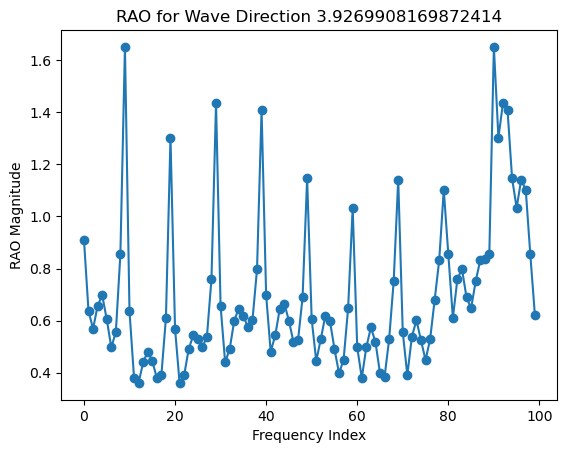

<xarray.Dataset>
Dimensions:                (omega: 1, radiating_dof: 600, influenced_dof: 600,
                            wave_direction: 1)
Coordinates:
  * omega                  (omega) float64 0.5852
  * radiating_dof          (radiating_dof) object '0_0__Surge' ... '9_9__Yaw'
  * influenced_dof         (influenced_dof) object '0_0__Surge' ... '9_9__Yaw'
  * wave_direction         (wave_direction) float64 3.927
    g                      float64 ...
    rho                    int64 ...
    body_name              object ...
    water_depth            float64 ...
    wavelength             (omega) float64 ...
Data variables:
    added_mass             (omega, radiating_dof, influenced_dof) float64 ...
    radiation_damping      (omega, radiating_dof, influenced_dof) float64 ...
    diffraction_force      (omega, wave_direction, influenced_dof) complex128 ...
    Froude_Krylov_force    (omega, wave_direction, influenced_dof) complex128 ...
    inertia_matrix         (influenced_dof, radiating_dof) float64 ...
    hydrostatic_stiffness  (influenced_dof, radiating_dof) float64 ...
    excitation_force       (omega, wave_direction, influenced_dof) complex128 ...
    rao                    (omega, radiating_dof) complex128 (10.303137560261...
Attributes:
    creation_of_dataset:        2023-09-01T10:40:17.020728
    incoming_waves_convention:  nemoh
    capytaine_version:          1.5

In [2]:
# Example usage:

DM_V.verify_hydrodynamic_data("data\DMFEM1010_5852_direction225_nosprace_m3_new.nc",wave_direction=np.pi*5/4)

In [2]:
# main 
if __name__ == "__main__":
    N = 3721   # Suppose the number of nodes is 22801(2*2) 3721(5*5)

    # Obtain the dataset
    dataset = merge_complex_values(xr.open_dataset("data\DMFEM1010_5852_direction225_nosprace_m3_new.nc"))
    
    # Extract matrices and force from the dataset
    added_mass = dataset['added_mass'][0].values
    radiation_damping = dataset['radiation_damping'][0].values
    inertia_matrix = dataset['inertia_matrix'].values
    hydrostatic_stiffness = dataset['hydrostatic_stiffness'].values
    F_w = dataset['Froude_Krylov_force'][0].values + dataset['diffraction_force'][0].values
    
    # Construct the combined matrices
    M = added_mass + inertia_matrix  # Total mass
    C = radiation_damping  # Damping
    K = hydrostatic_stiffness  # Stiffness
    
    # Sample node ID list
    # node_ids = [41, 39, 37, 35, 33, 31, 29, 27, 25, 23]
    node_ids = DM_A.calculate_2d_node_positions_descending(3535,6,61,10,10) # Calculate the node positionscalculate_node_positions(425,6,10) 
    # print(node_ids)(3535,6,61,10,10)(21585,15,151,10,10) (3411,10,61,6,6)
    # Call function to insert the additional mass stiffness matrix into the total stiffness matrix
    mass = DM_A.sparse_insert_matrix(N, M, node_ids)
    damping = DM_A.sparse_insert_matrix(N, C, node_ids)
    hy_stiffness = DM_A.sparse_insert_matrix(N, K, node_ids)
    from scipy.sparse import csr_matrix
    # Obtain the structural stiffness matrix
    file_path = "data\model300_300\plate3340305.mtx"  # Replace with your file path
    stiffness = DM_R.get_stiffness_csr_matrix_optimized(file_path) + hy_stiffness

    # Assemble the force matrix
    K_F_w = csr_matrix(DM_A.extend_force_matrix(F_w, node_ids, N))
    
    omega = 0.5852  # Here we use 1.0 as an example, in actual applications you should use your real data
    import time
    # 开始计时
    start_time = time.time()
    X = DM_A.sparse_solve_frequency_domain(mass, damping, stiffness, K_F_w, omega)  # Solve in frequency domain
    end_time = time.time()
    # 计算运行时间
    runtime = end_time - start_time
    # 打印运行时间
    print(f"代码的运行时间为: {runtime} 秒")
    #处理稀疏矩阵的结果
    X = X.reshape(N*6,1)
    # 保存X
    # np.save('result_nosparse.npy', X)
#     # 在需要时加载X
#     X_loaded = np.load('result.npy')


代码的运行时间为: 20.94290065765381 秒


In [ ]:
import numpy as np
# 位移结果已经由超算计算得到，开展下一步对比工作
X = np.load(r'result_nosparse.npy')
# X2 = np.load(r'result_nosparse.npy')
# import scienceplots
# plt.style.use(['science','no-latex','ieee'])

In [ ]:
X.shape

In [ ]:
# forceAnalysis
from DM_forec_analysis import ForceAnalysis
analyzer = ForceAnalysis(N=3721, H=61, module_nodes=7, module_number=100, module_distribution="2D",module_cols=10,module_rows=10,element_length=5, element_width=5)

# Compute module displacements using the provided displacement matrix X
module_displacements = analyzer.compute_module_displacements(displacement_matrix=X)

# Fetch the stiffness matrix for an element from a specified file
K_element = DM_R.get_stiffness_matrix("data\model300_300\plate334_sub.mtx")

# Compute forces within the module using the stiffness matrix and module displacements
module_forces = analyzer.compute_module_forces(K_element, module_displacements)

# Map the forces from module level to global nodes
global_forces = analyzer.map_forces_to_global_nodes(module_forces)

# Visualize global forces using a plot
analyzer.plot_forces(global_forces)

M = analyzer.get_middle_interface_forces(global_forces)
# # Display global forces as a 2D heatmap
# analyzer.plot_2D_heatmap(global_forces)

# # Display global forces as a 3D surface plot
# analyzer.plot_3D_surface(global_forces)

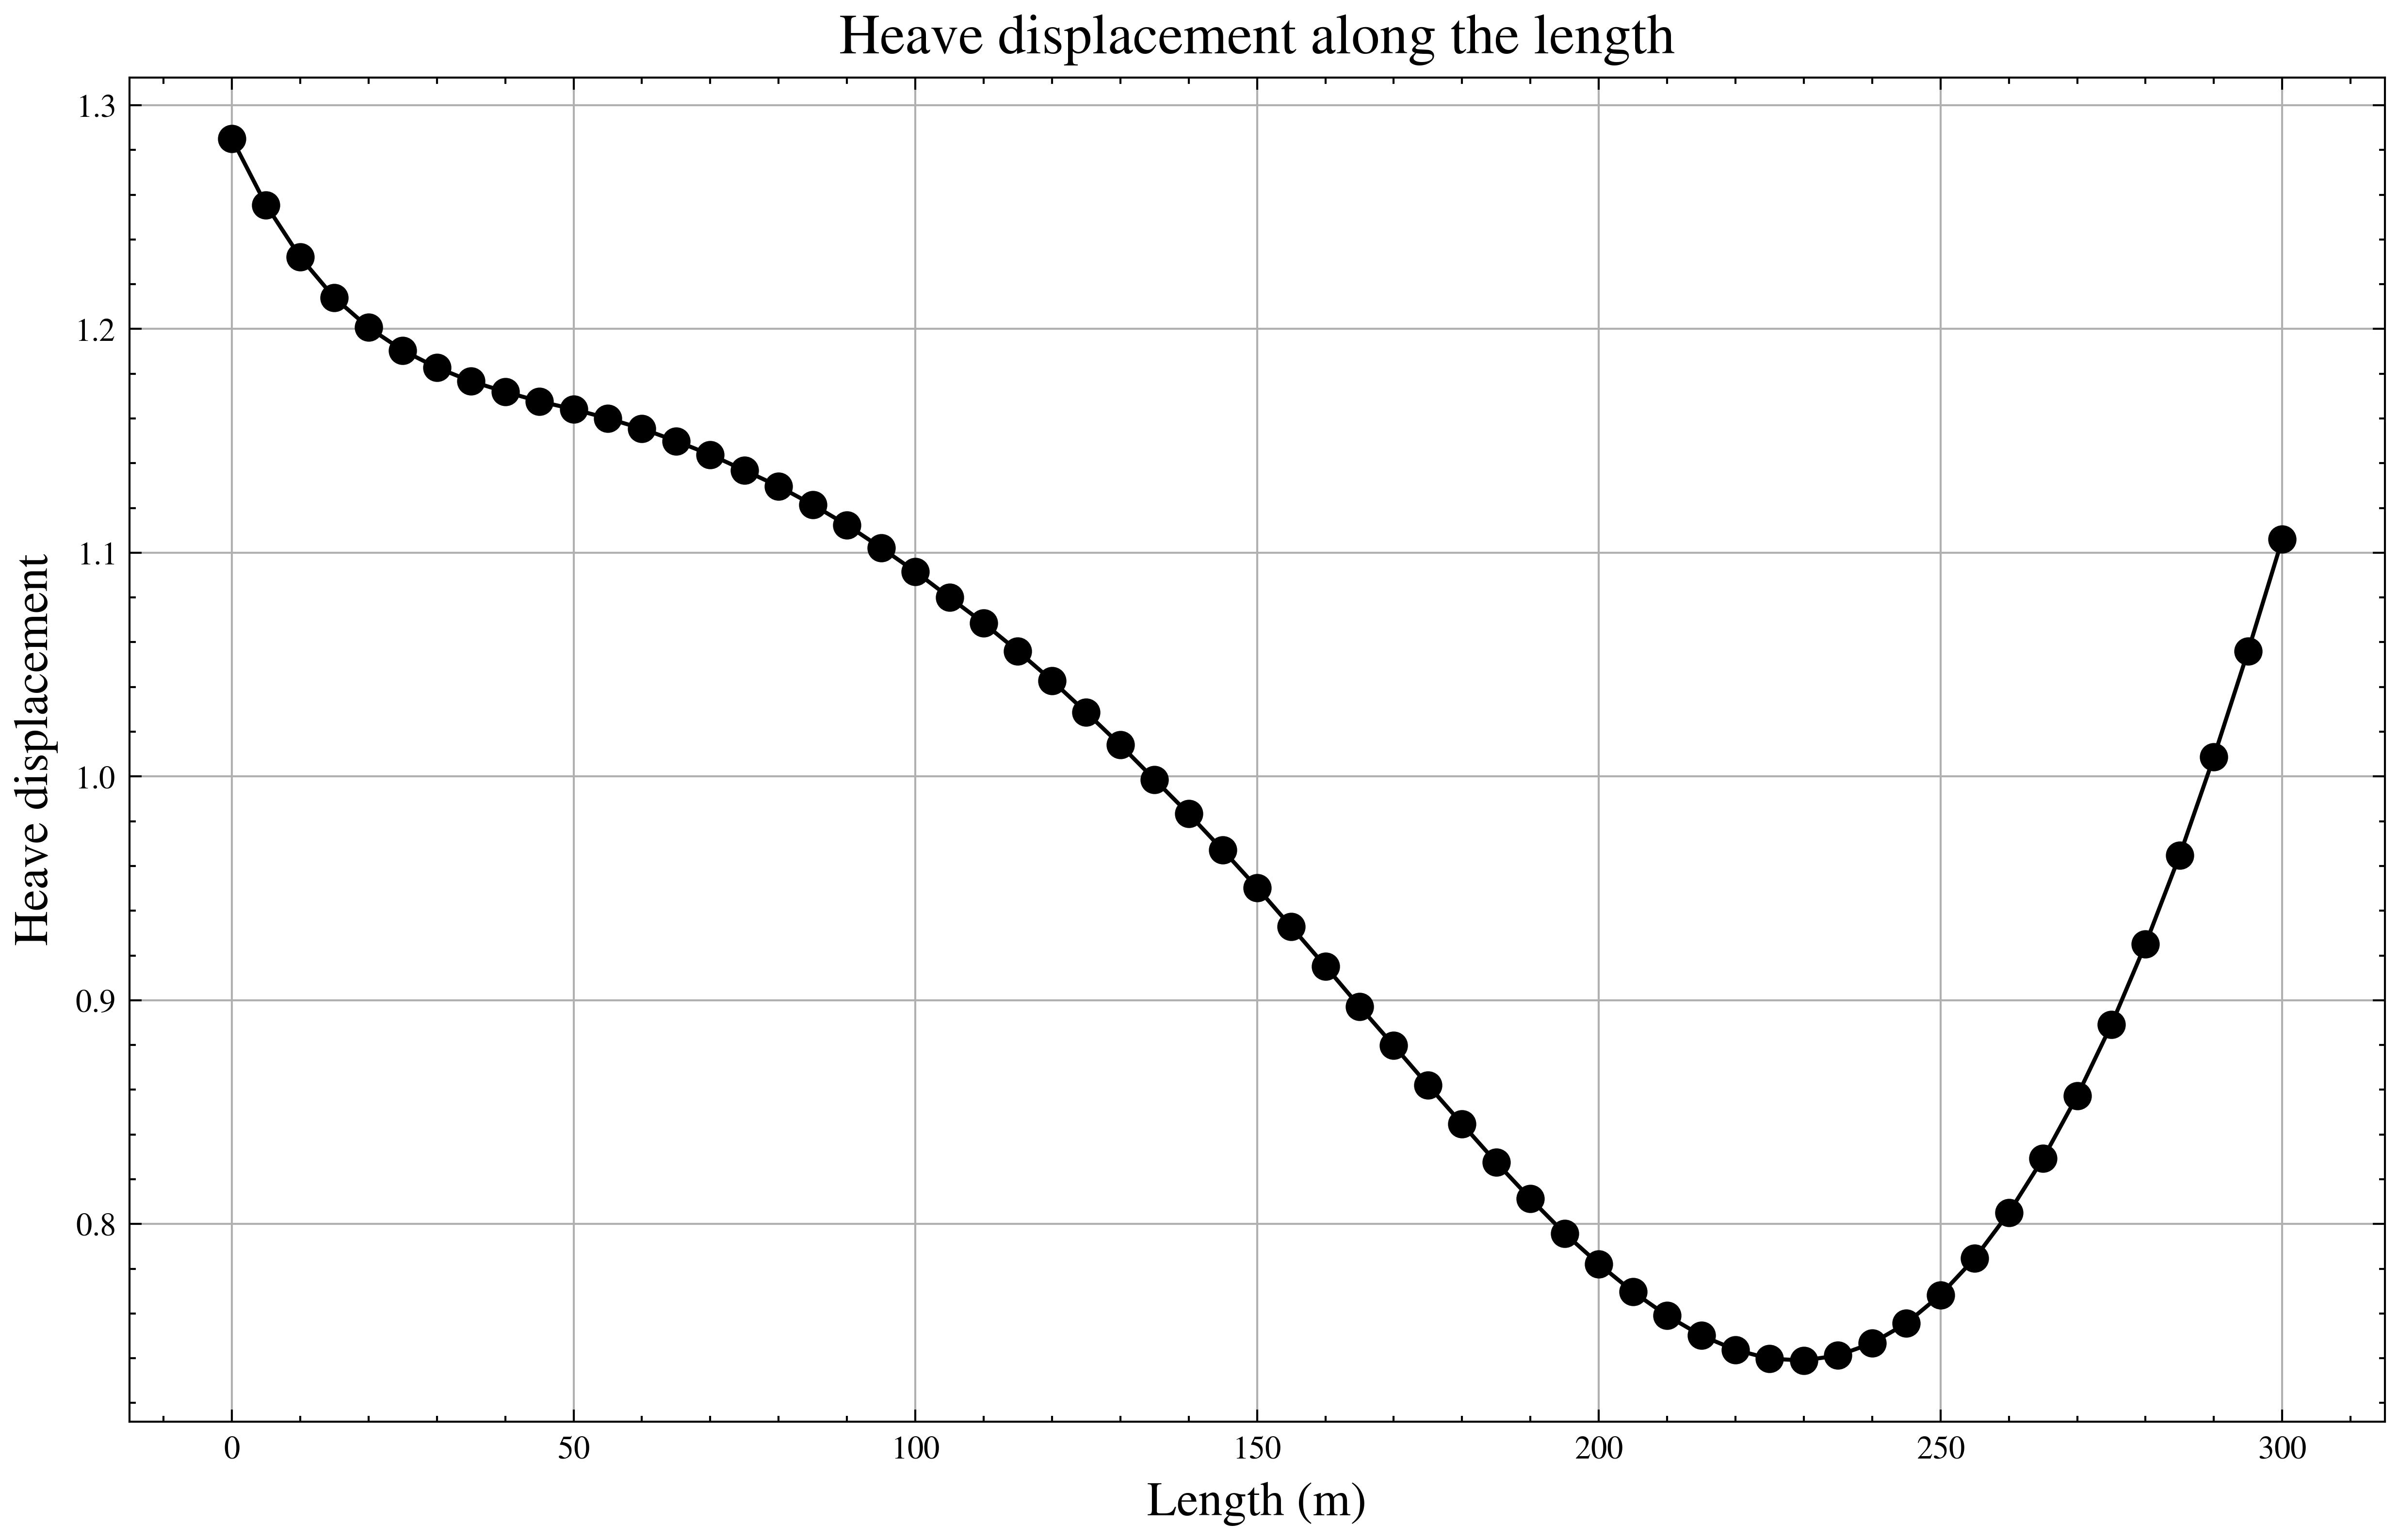

In [10]:
# Show heave displacement
import matplotlib.pyplot as plt
displacement = X
# 提取中轴线上的节点位移
mid_axis_nodes_start = 3661  # 起始节点1-61，3661-3721 ，3661-0*61 ，3721-0*61
mid_axis_nodes_end = 3721 # 结束节点1831-1891

# 由于每个节点有6个自由度，我们需要找到与这些节点对应的位移
mid_axis_displacement = displacement[(mid_axis_nodes_start-1)*6:(mid_axis_nodes_end)*6:6, :]

# 垂荡位移应该是Y轴（第2个自由度）的位移，我们需要每6个自由度取一次
heave_displacement = displacement[(mid_axis_nodes_start-1)*6+2:(mid_axis_nodes_end)*6:6, :]

# 定义节点在长度方向上的位置
length = np.linspace(0, 300, mid_axis_nodes_end-mid_axis_nodes_start+1)

# 绘制位移曲线
plt.figure(figsize=(10, 6))
plt.plot(length, np.abs(heave_displacement), marker='o')  # 绘制垂荡位移的绝对值
plt.xlabel("Length (m)", fontsize=12)
plt.ylabel("Heave displacement", fontsize=12)
plt.title("Heave displacement along the length", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
# Show heave displacement mesh 2*2
import matplotlib.pyplot as plt
displacement = X
# 提取中轴线上的节点位移
mid_axis_nodes_start = 1  # 起始节点1-61，3661-3721 ，3661-0*61 ，3721-0*61
mid_axis_nodes_end = 151 # 结束节点1831-1891

# 由于每个节点有6个自由度，我们需要找到与这些节点对应的位移
mid_axis_displacement = displacement[(mid_axis_nodes_start-1)*6:(mid_axis_nodes_end)*6:6, :]

# 垂荡位移应该是Y轴（第2个自由度）的位移，我们需要每6个自由度取一次
heave_displacement = displacement[(mid_axis_nodes_start-1)*6+2:(mid_axis_nodes_end)*6:6, :]

# 定义节点在长度方向上的位置
length = np.linspace(0, 300, mid_axis_nodes_end-mid_axis_nodes_start+1)

# 绘制位移曲线
plt.figure(figsize=(10, 6))
plt.plot(length, np.abs(heave_displacement), marker='o')  # 绘制垂荡位移的绝对值
plt.xlabel("Length (m)", fontsize=12)
plt.ylabel("Heave displacement", fontsize=12)
plt.title("Heave displacement along the length", fontsize=14)
plt.grid(True)
plt.show()

In [11]:
# Test the function using the provided data
from DM_Verify import process_exp_data
x, y = process_exp_data("data\Experiment_300_300\dis_3.txt")
y = np.array(y)

Text(0, 0.5, 'Heave RAO ($m$/$m$)')

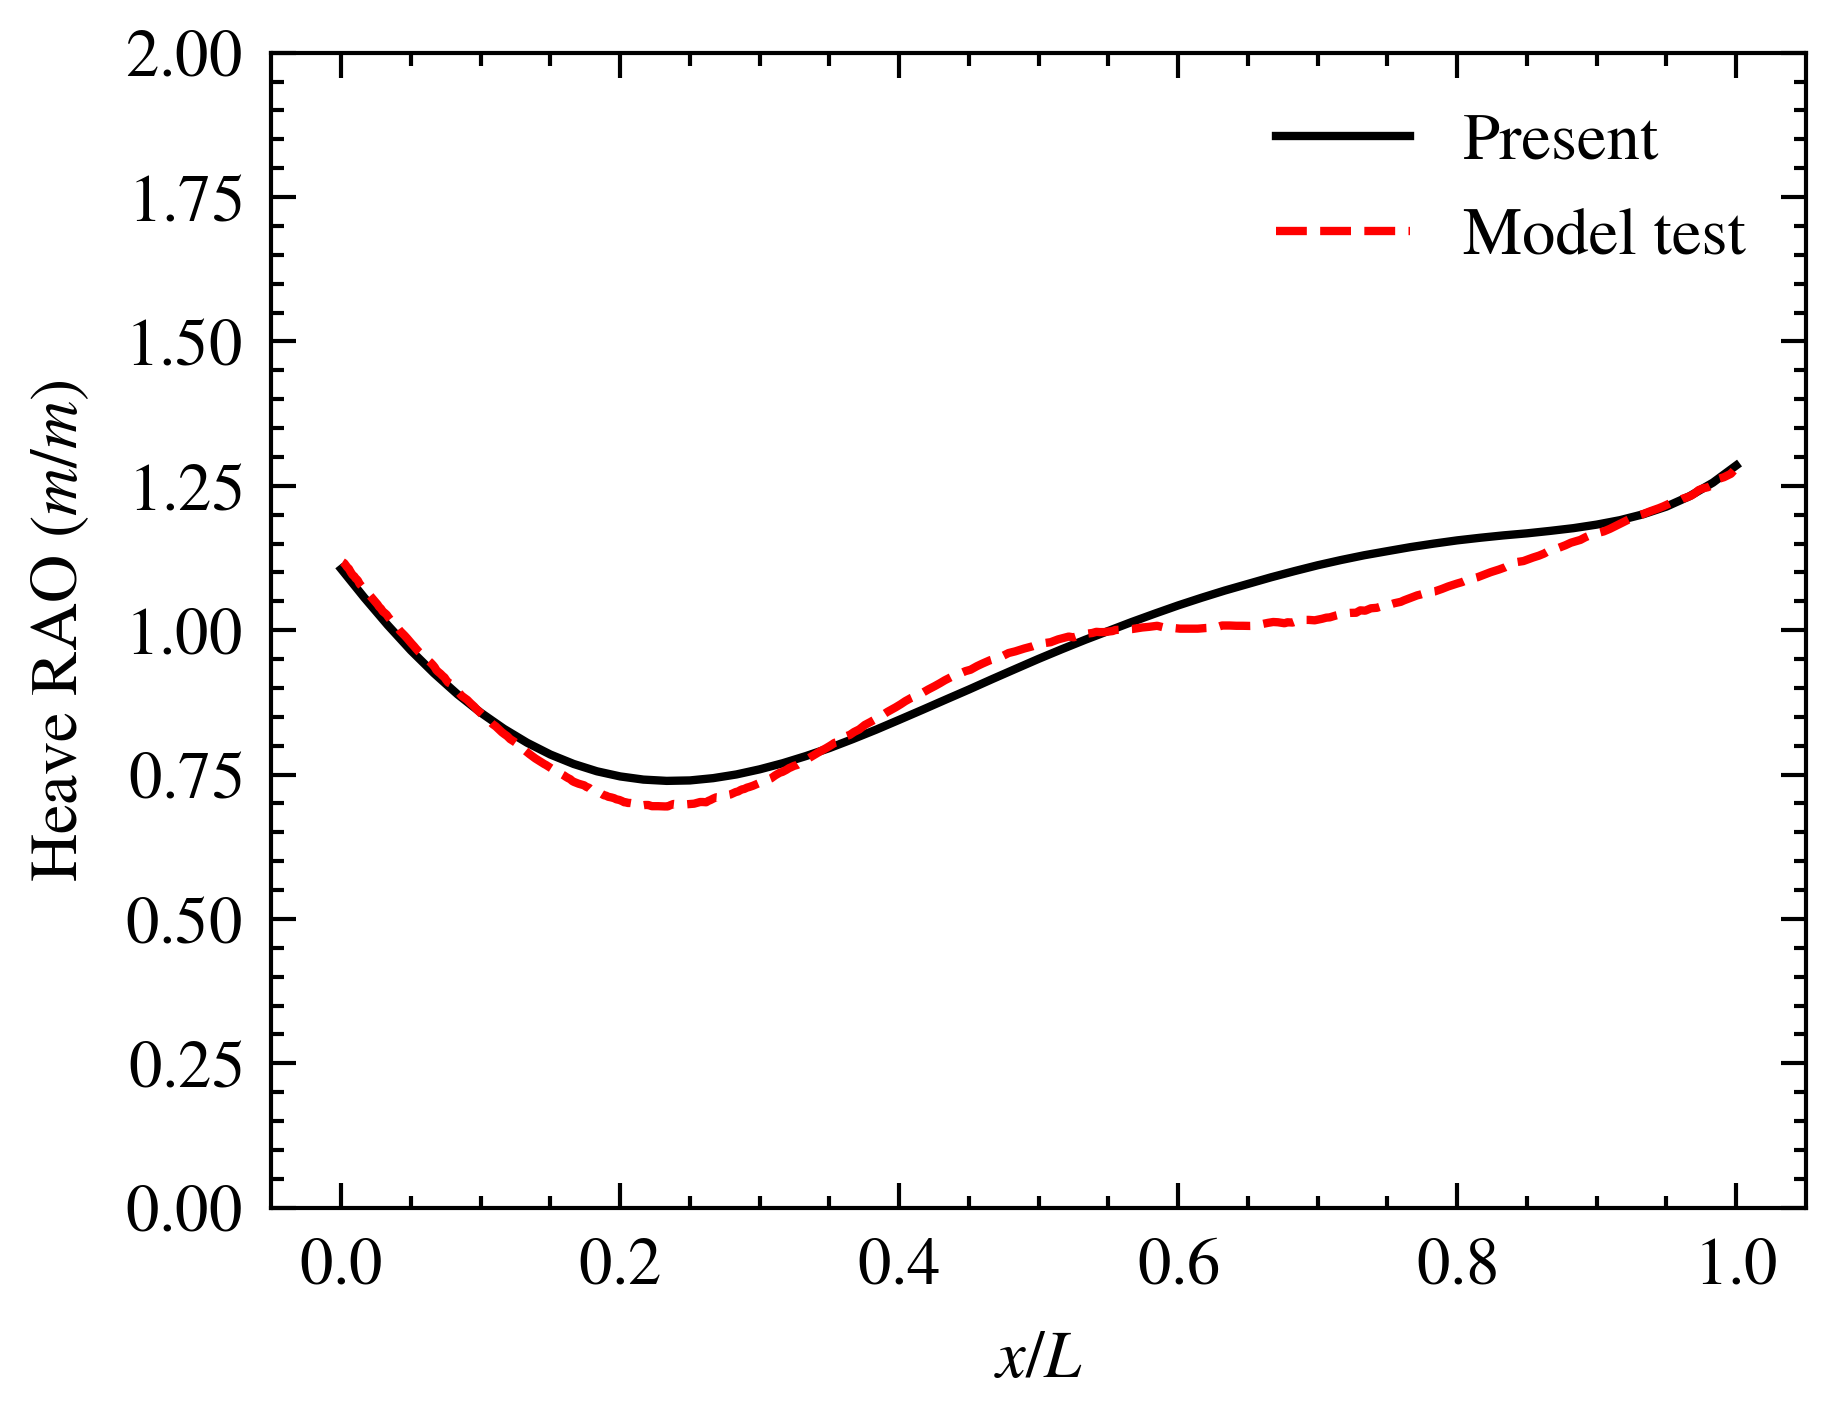

In [12]:
# 绘制位移图像
import scienceplots
plt.style.use(['science','no-latex','ieee'])
plt.plot(length/300,abs(heave_displacement[::-1]), label="Present")
plt.plot(x,y,color = 'red',label="Model test")
plt.legend() 
plt.ylim(0,2) # 调整y轴坐标
plt.xlabel(r'$x/L$',)
plt.ylabel(r'Heave RAO ($m$/$m$)')
# plt.savefig('Validation_d.pdf',dpi = 600)

In [ ]:
# 绘制内力图
exp_x, exp_y = process_exp_data(r"data\Experiment_300_300\force2.txt")
exp_y = np.array(exp_y)
data = analyzer.get_middle_interface_forces(global_forces)

# global_forces

x = np.arange(len(data))
y = data[:, 0]
from scipy import interpolate
spline = interpolate.CubicSpline(x, y)
x_new = np.linspace(0, len(data)-1, 300)
y_new = spline(x_new)
plt.plot(exp_x,exp_y,color = 'red', label = 'Yoon et al.')
plt.scatter(x/10, y/1e6, color='black', s=10,label='Interface')
plt.plot(x_new/10, y_new/1e6,color ='black', label='Present')
plt.legend()
# plt.title("Scatter Plot and Cubic Spline Interpolation")
plt.xlabel(r"$x$/$L$")
plt.ylabel(r"$M_y$($MN{\cdot}m$)")
plt.ylim(0,1.1)
# plt.savefig("inter_force_my.pdf",dpi=600)



In [ ]:
M = global_forces.reshape(6*3721,1)[4::6]


In [ ]:
x = np.arange(0,11)
plt.plot(x/10,abs(M[0:61:6]/5)/1e6)
exp_x, exp_y = process_exp_data(r"data\Experiment_300_300\force3.txt")
plt.plot(exp_x,exp_y)

In [ ]:
X1 = np.load(r'result.npy')
X2 = np.load(r'result_nosparse.npy')
X1 = X1.reshape(22326,1)
Heave1 = X1[2::6]
X2 = X2.reshape(22326,1)
Heave2 = X2[2::6]

In [ ]:
plt.plot(np.linspace(0,1,61),abs(Heave1[0:61]),label = "1.3*3")
plt.plot(np.linspace(0,1,61),abs(Heave2[0:61]),label = "2.4*4")
plt.plot(x,y,color = 'red',label="Model test")
plt.legend()
plt.show()

In [ ]:
node_ids = DM_A.calculate_2d_node_positions_descending(3535,6,61,10,10)

In [ ]:
node_ids[-11:]